In [1]:
from pathlib import Path
from os.path import expanduser
from os import path
import numpy as np
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import os

In [2]:
max_dataset_size = 6000000
waveform_length = 72;
nb_of_elements = 100000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
root_folder = os.path.dirname(os.getcwd())
path_to_recording= path.join(root_folder,'data/recording_datasets/datasets_1.npy');
path_to_ground_truth_data = path.join(root_folder,'data/recording_datasets/ground_truth_data_multiunit_1.npy');
path_to_train_data = path.join(root_folder,'data/train_data.npy');
path_to_train_labels = path.join(root_folder,'data/train_labels.npy');
path_to_noise_data = path.join(root_folder,'data/noise_data.npy');
path_to_mean_std = path.join(root_folder,'data/mean_std.npy');
sys.path.append(root_folder)
from custom_resnet import CustomResnet as cnn

In [4]:
noise_indices = cnn.GetNoiseIndices(path_to_recording, path_to_ground_truth_data, waveform_length, nb_of_elements);



In [5]:
noise_class = torch.zeros(1, noise_indices.nelement(), dtype= torch.int);
noise_data = torch.cat((noise_indices, noise_class), 0);


In [6]:
np.save(path_to_noise_data, noise_data.numpy());

In [7]:
dataset_spikes = cnn.GenerateDataset(path_to_recording, path_to_ground_truth_data, waveform_length, max_dataset_size);


========== 1 generation ==========
temp_dataset_len:  0
shift_from:  -18
shift_to:  19
shift_step:  2
shift_indexes:  tensor([-18, -16, -14, -12, -10,  -8,  -6,  -4,  -2,   0,   2,   4,   6,   8,
         10,  12,  14,  16,  18], dtype=torch.int32)
snr_ratio:  None
flip_data 2


/home/vtpc/Documents/Alvils/spike-sorting/custom_resnet/CustomResnet.py:291: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  temp = temp.new_tensor(data);


temp_dataset_len_after:  0 968202
temp_dataset_len_after:  1 1936404
dataset len:  1 1936404
========== 2 generation ==========
temp_dataset_len:  0
shift_from:  -9
shift_to:  17
shift_step:  4
shift_indexes:  tensor([-9, -5, -1,  3,  7, 11, 15], dtype=torch.int32)
snr_ratio:  12.490311607142985
flip_data 1
temp_dataset_len_after:  0 356706
dataset len:  0 2293110
========== 3 generation ==========
temp_dataset_len:  0
shift_from:  -3
shift_to:  2
shift_step:  3
shift_indexes:  tensor([-3,  0], dtype=torch.int32)
snr_ratio:  14.87322987875075
flip_data 2
temp_dataset_len_after:  0 101916
temp_dataset_len_after:  1 203832
dataset len:  1 2496942
========== 4 generation ==========
temp_dataset_len:  0
shift_from:  -18
shift_to:  7
shift_step:  4
shift_indexes:  tensor([-18, -14, -10,  -6,  -2,   2,   6], dtype=torch.int32)
snr_ratio:  14.353938601399477
flip_data 1
temp_dataset_len_after:  0 356706
dataset len:  0 2853648
========== 5 generation ==========
temp_dataset_len:  0
shift_from

In [8]:
dataset_noise = cnn.GenerateDataset(path_to_recording, path_to_noise_data, waveform_length, max_dataset_size);


========== 1 generation ==========
temp_dataset_len:  0
shift_from:  -18
shift_to:  19
shift_step:  1
shift_indexes:  tensor([-18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,
         -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
         10,  11,  12,  13,  14,  15,  16,  17,  18], dtype=torch.int32)
snr_ratio:  None
flip_data 1
temp_dataset_len_after:  0 3700000
dataset len:  0 3700000
========== 2 generation ==========
temp_dataset_len:  0
shift_from:  -14
shift_to:  16
shift_step:  4
shift_indexes:  tensor([-14, -10,  -6,  -2,   2,   6,  10,  14], dtype=torch.int32)
snr_ratio:  22.087391470728168
flip_data 2
temp_dataset_len_after:  0 800000
temp_dataset_len_after:  1 1600000
dataset len:  1 5300000
========== 3 generation ==========
temp_dataset_len:  0
shift_from:  -14
shift_to:  13
shift_step:  2
shift_indexes:  tensor([-14, -12, -10,  -8,  -6,  -4,  -2,   0,   2,   4,   6,   8,  10,  12],
       dtype=torch.int32)
snr_ratio:  27.58193

In [9]:
dataset_size =  dataset_spikes.__len__() if dataset_spikes.__len__() < dataset_noise.__len__() else  dataset_noise.__len__()

In [10]:
# convers to np array
np_data_spikes = np.zeros((dataset_size, 1, waveform_length));
for i, (data, target) in enumerate(dataset_spikes):
  np_data_spikes[i, :] = data.numpy();
  if(i + 1 == dataset_size):
    break;
    
del dataset_spikes

# removes spikes that have mutiple spikes in waveform
spike_argmax = np.argmax(np_data_spikes, 2)
over_treshold = waveform_length // 2 + waveform_length // 4
under_treshold = waveform_length // 2 - waveform_length // 4
is_valid_train_data = ((spike_argmax >= under_treshold) & (spike_argmax <= over_treshold)).ravel()
np_data_spikes = np_data_spikes[is_valid_train_data, :, :]
dataset_size = np_data_spikes.shape[0]
np_classes_spikes = np.ones(dataset_size)


np_data_noise = np.zeros((dataset_size, 1, waveform_length));
np_classes_noise = np.zeros(dataset_size)
for i, (data, target) in enumerate(dataset_noise):
  np_data_noise[i, :] = data.numpy();
  if(i + 1 == dataset_size):
    break;
    
del dataset_noise

    


In [11]:
np_data_noise.shape

(6954759, 1, 72)

In [12]:
dataset = np.concatenate((np_data_spikes, np_data_noise), 0);

In [13]:
labels = np.concatenate((np_classes_spikes, np_classes_noise), 0); 

In [14]:
np.save(path_to_train_data, dataset)
np.save(path_to_train_labels, labels)


In [15]:
mean = (np.mean(np_data_spikes))
std = (np.std(np_data_spikes))
np.save(path_to_mean_std, [mean, std])

print(mean)
print(std)

0.0840876824901527
0.36588591942819065


21

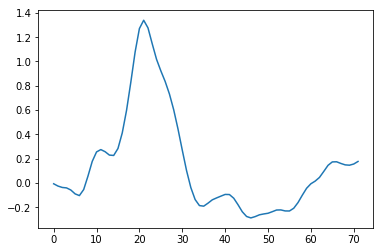

In [16]:
import matplotlib.pyplot as plt
rnd = np.random.randint(0, dataset_size);
plt.plot(np_data_spikes[rnd, 0, :])
np.argmax(np_data_spikes[rnd, 0, :])